In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import torch
import pyro

In [2]:
from pyro.infer import Predictive

In [3]:
from monteloanco import model, guide, simulate_portfolio_from_samples

### Load the data and model

Here we load the subset of accounts used for training earlier and the weights into the model.

In [4]:
device = 'cuda:0'
embedding_size = 3

In [5]:
df = pd.read_json('scoring.jsonl.gz', lines=True)

In [6]:
df.pymnt = df.pymnt.apply(torch.tensor)

In [7]:
pyro.get_param_store().load('param_store.pt')

/home/daniel/monteloanco/.venv/lib/python3.10/site-packages/pyro/params/param_store.py:334: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(input_file, map_

### Perform test simulation

Here we take an single loan at random and simulate its performance 100 times. We then take the model outputs and plot the profiles of the first 10 individually for clarity, then all 100 showing the median loan status and cashflows with 95% confidence bands.

In [8]:
loan = df.sample(1).squeeze()
print(loan)

predictive = Predictive(
    model,
    guide=guide,
    num_samples=10,
    return_sites=None,
)

samples = predictive(
    batch_id=loan.batch_id,
    batch_idx=torch.tensor(loan.batch_idx).unsqueeze(0).to(device),
    installments=torch.tensor(loan.installment).unsqueeze(0).to(device),
    loan_amnt=torch.tensor(loan.loan_amnt).unsqueeze(0).to(device),
    int_rate=torch.tensor(loan.int_rate).unsqueeze(0).to(device),
    num_timesteps=loan.n_report_d,
)

portfolio = simulate_portfolio_from_samples(
    samples, loan, loan.batch_id, num_samples=10,
    num_timesteps=loan.n_report_d, device=device
)

hidden_states, sim_pymnts, interest_paid, principal_paid = portfolio.get_histories().values()

batch_idx                                                          24732
id                                                             125195240
batch_id                                                               0
report_d               [2018-01-01T00:00:00.000, 2018-02-01T00:00:00....
pymnt                  [tensor(109.5656), tensor(109.5656), tensor(10...
loan_amnt                                                           5000
int_rate                                                           10.42
installment                                                       162.33
n_report_d                                                            15
total_pre_chargeoff                                              1086.09
last_pymnt_amnt                                                    100.0
score                                                           0.002017
Name: 24732, dtype: object


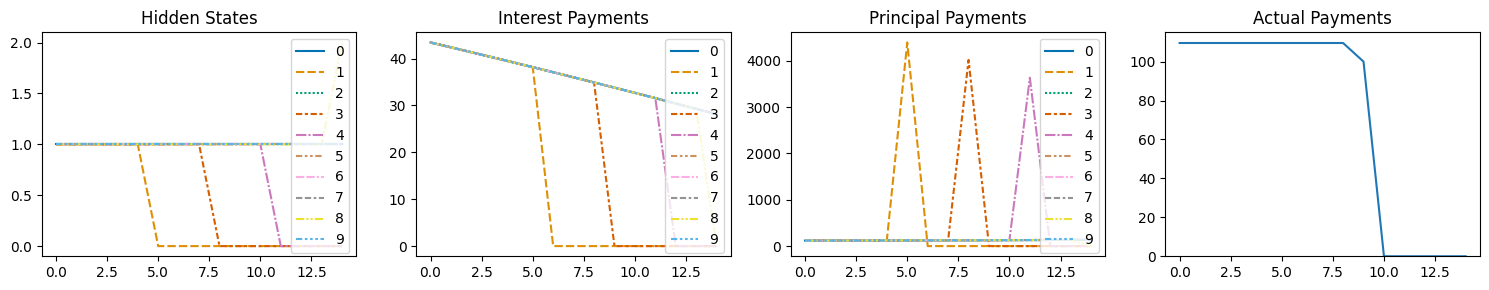

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3))
sns.lineplot(hidden_states.cpu().detach().numpy()[:,:10], ax=ax[0], palette='colorblind')
sns.lineplot(interest_paid.cpu().detach().numpy()[:,:10], ax=ax[1], palette='colorblind')
sns.lineplot(principal_paid.cpu().detach().numpy()[:,:10], ax=ax[2], palette='colorblind')
sns.lineplot(loan.pymnt.cpu(), ax=ax[3])
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Interest Payments")
ax[2].set_title(f"Principal Payments")
ax[3].set_title(f"Actual Payments")
ax[3].set_ylim(0)
plt.tight_layout()
plt.show()

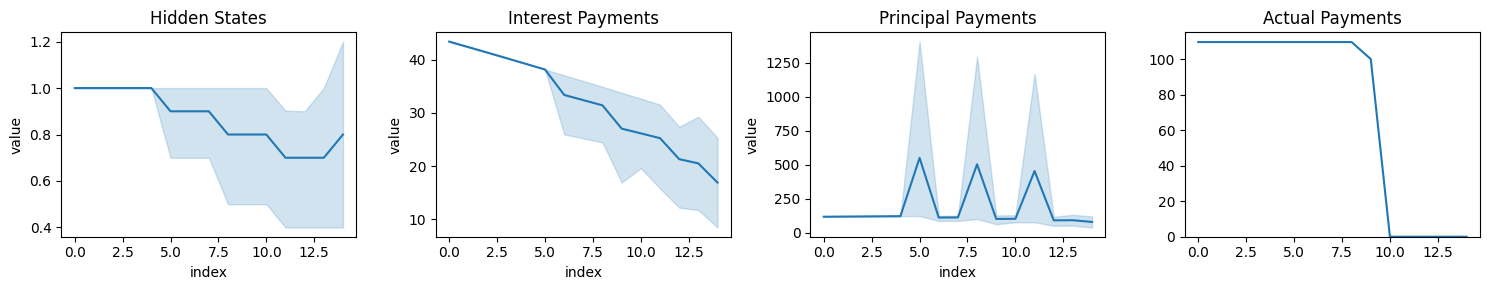

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3))
sns.lineplot(pd.DataFrame(hidden_states.cpu().detach().numpy()).reset_index().melt(id_vars='index'), x='index', y='value', errorbar=('ci', 95), ax=ax[0])
sns.lineplot(pd.DataFrame(interest_paid.cpu().detach().numpy()).reset_index().melt(id_vars='index'), x='index', y='value', errorbar=('ci', 95), ax=ax[1])
sns.lineplot(pd.DataFrame(principal_paid.cpu().detach().numpy()).reset_index().melt(id_vars='index'), x='index', y='value', errorbar=('ci', 95), ax=ax[2])
sns.lineplot(loan.pymnt.cpu(), ax=ax[3])
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Interest Payments")
ax[2].set_title(f"Principal Payments")
ax[3].set_title(f"Actual Payments")
ax[3].set_ylim(0)
plt.tight_layout()
plt.show()

### Simulate full training set

The section below iterates again over the same-length batches used to train the model. The difference here is we don't supply the outcomes, giving us just the model outputs, without updating any parameters. We simulate only for `n_report_d` here, not the full term of the loan, so we can compare the output of the simulations with the actual loans' performance.

In [11]:
batch_size = 100_000
dataset = df[['id', 'loan_amnt', 'int_rate', 'installment', 'n_report_d', 'total_pre_chargeoff']].to_dict(orient='records')
dataset.__getitem__(42)

{'id': 79661304,
 'loan_amnt': 10000,
 'int_rate': 7.39,
 'installment': 310.56,
 'n_report_d': 33,
 'total_pre_chargeoff': 10008.44}

In [12]:
from torch.utils.data import DataLoader

In [13]:
predictive = Predictive(model, guide=guide, num_samples=1, return_sites=None)

all_hidden_states, all_sim_pymnts, all_interest_paid, all_principal_paid = [], [], [], []
all_total_payments, all_last_payments = [], []

for batch_id, batch in enumerate(DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)):
    batch_size_actual = len(batch['id'])
    start_idx = batch_id * batch_size
    batch_idx = torch.arange(start_idx, start_idx + batch_size_actual).to(device)

    samples = predictive(
        batch_id=batch_id,
        batch_idx=torch.arange(len(batch['id'])).to(device),
        installments=batch['installment'].to(device),
        loan_amnt=batch['loan_amnt'].to(device),
        int_rate=batch['int_rate'].to(device),
        num_timesteps=batch['n_report_d'].to(device),
    )

    portfolio = simulate_portfolio_from_samples(
        samples=samples,
        loan=batch,
        bid=batch_id,
        num_samples=1,
        num_timesteps=batch['n_report_d'].to(device),
        device=device,
    )

    histories = portfolio.get_histories()
    all_hidden_states.append(histories['hidden_states'].cpu())
    all_sim_pymnts.append(histories['payments'].cpu())
    all_interest_paid.append(histories['interest_paid'].cpu())
    all_principal_paid.append(histories['principal_paid'].cpu())
    all_total_payments.append(portfolio.get_total_pre_chargeoff().cpu())
    all_last_payments.append(portfolio.get_last_payment().cpu())

hidden_states  = torch.cat(all_hidden_states,  dim=1)
sim_pymnts     = torch.cat(all_sim_pymnts,     dim=1)
interest_paid  = torch.cat(all_interest_paid,  dim=1)
principal_paid = torch.cat(all_principal_paid, dim=1)
total_payments = torch.cat(all_total_payments, dim=0)  # (n_loans,)
last_payments  = torch.cat(all_last_payments,  dim=0)  # (n_loans,)

### Validate results

Calculating the total value of all cashflows from the simulations provides a quick means of validating the results against the actual receipts. Below we see the results as overall totals, and split by 11 score (default probability) bands, all showing good agreement between simulation and observation.

In [14]:
from sklearn.metrics import root_mean_squared_error, r2_score

In [15]:
df["sim_pymnts_sum"] = total_payments * portfolio.scaling_factor

In [16]:
df[['total_pre_chargeoff', 'sim_pymnts_sum']].sum().map('${:,.0f}'.format)

total_pre_chargeoff    $1,196,028,649
sim_pymnts_sum         $1,230,028,017
dtype: object

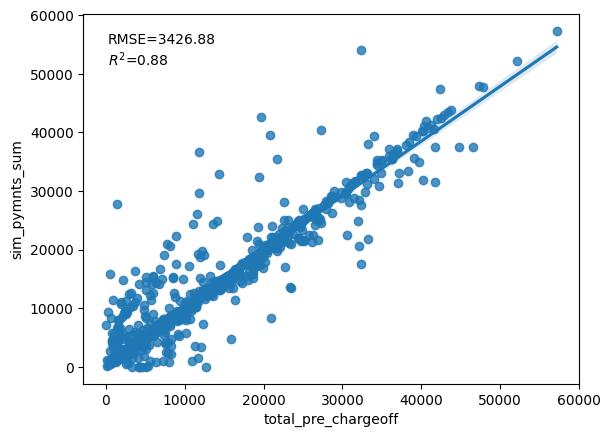

In [17]:
x = df['total_pre_chargeoff']
y = df['sim_pymnts_sum']

rmse = root_mean_squared_error(y, x)
r2 = r2_score(y, x)

sns.regplot(data=df.sample(1_000), x='total_pre_chargeoff', y='sim_pymnts_sum', ci=95)

plt.text(0.05, 0.95, f"RMSE={rmse:.2f}\n$R^2$={r2:.2f}",
         transform=plt.gca().transAxes, va='top')

plt.show()

In [18]:
df["predicted_last"] = last_payments * portfolio.scaling_factor

In [19]:
df[['last_pymnt_amnt', 'predicted_last']].sum().map('${:,.0f}'.format)

last_pymnt_amnt    $343,326,996
predicted_last     $398,848,665
dtype: object

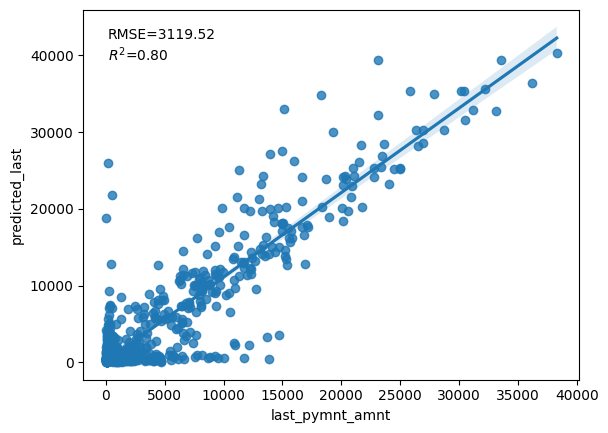

In [20]:
x = df['last_pymnt_amnt']
y = df['predicted_last']

rmse = root_mean_squared_error(y, x)
r2 = r2_score(y, x)

sns.regplot(data=df.sample(1_000), x='last_pymnt_amnt', y='predicted_last', ci=95)

plt.text(0.05, 0.95, f"RMSE={rmse:.2f}\n$R^2$={r2:.2f}",
         transform=plt.gca().transAxes, va='top')

plt.show()